### Imports

In [9]:
from sentence_transformers import SentenceTransformer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy as sc

# Special imports for plots
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [67]:
# Imports for the widgets
from ipywidgets import widgets
from IPython.display import display, clear_output

### Dataframe and loading in the model

In [5]:
df = pd.read_csv('Tiny_dataset_embeddings.csv')

In [8]:
model = SentenceTransformer('mixedbread-ai/mxbai-embed-large-v1')

### Embedding the text

In [11]:
embedding = model.encode(df["text"])
embedding = embedding.tolist()
df.insert(1,"embedding",embedding)

In [12]:
text_embeddings = np.vstack(df["embedding"].values)
print(text_embeddings.shape)

(25, 1024)


### Defining the centroids

In [59]:
centroid_indices = [23,15,9]
category_names = ["Career Opportunities", "Social Life", "Learning"]

In [60]:
centroid_embeddings = []
for category in centroid_indices:
    centroid_embeddings.append(df.embedding[category])

centroid_embeddings = np.array(centroid_embeddings)

In [62]:
print(centroid_embeddings)

[[-0.10171032 -0.66125387  0.04628319 ... -0.3866047   0.58760482
  -0.04861117]
 [ 0.08614749 -0.55423903 -0.52589643 ... -0.8194415   0.21966261
  -0.50483477]
 [ 0.62528521  0.37743202 -1.17989814 ... -0.0089976  -0.14488989
  -0.40004158]]


### Scoring

In [63]:
def embedding_score(text_embeddings, centroid_embeddings, alpha, metric, scaling, rounding=False):

    # Check that the input is valid
    assert scaling in ["exponential", "power"]
    assert metric in ["cosine", "euclidean", "cityblock"]

    # Calculating distances using scipy.spatial.distance.cdist function
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    distances = sc.spatial.distance.cdist(text_embeddings, centroid_embeddings, metric=metric)

    # Scale and invert the distances according to the specified scaling
    if scaling == "exponential":
        score = 1/np.exp(alpha*distances)
    if scaling == "power":
        score = 1/(distances**alpha)

    # L1 norm the scores to get a probability distribution
    score /= score.sum(axis=1)[:,None]

    # Round the scores to 2 decimals if specified
    if rounding:
        # Set all values below 0.01 to 0
        score[score <=0.01] = 0
        score /= score.sum(axis=1)[:,None]

    return score

#### Scoring with $\alpha = 1$

In [64]:
texts = text_embeddings   # the matrix of all the embeddings from earlier
centroids = centroid_embeddings   # the embedded centroids we made in part 3

alpha = 1    # an initial alpha value
metric = 'cosine'   # Cosine Similarity
scaling = 'power'   # Power scaling

scores = embedding_score(texts, centroids, alpha, metric, scaling)

print(scores[:5])

[[0.22337168 0.23296672 0.5436616 ]
 [0.36213365 0.33066469 0.30720166]
 [0.32947928 0.32618503 0.3443357 ]
 [0.20835168 0.20070987 0.59093845]
 [0.32037715 0.3611624  0.31846046]]


C:\Users\maria\AppData\Local\Temp\ipykernel_14860\3187089756.py:15: RuntimeWarning: divide by zero encountered in divide
  score = 1/(distances**alpha)
C:\Users\maria\AppData\Local\Temp\ipykernel_14860\3187089756.py:18: RuntimeWarning: invalid value encountered in divide
  score /= score.sum(axis=1)[:,None]


#### Scoring with $\alpha = 50$

In [43]:
texts = text_embeddings   # the matrix of all the embeddings from earlier
centroids = centroid_embeddings   # the embedded centroids we made in part 3

alpha = 50    # an initial alpha value
metric = 'cosine'   # Cosine Similarity
scaling = 'power'   # Power scaling

In [44]:
scores = embedding_score(texts, centroids, alpha, metric, scaling)

print(scores[:5])

[[4.84141326e-20 3.96516929e-19 1.00000000e+00]
 [9.89233764e-01 1.05013659e-02 2.64870212e-04]
 [9.36598800e-02 5.66694851e-02 8.49670635e-01]
 [2.30535336e-23 3.55896676e-24 1.00000000e+00]
 [2.48922432e-03 9.95666765e-01 1.84401031e-03]]


C:\Users\maria\AppData\Local\Temp\ipykernel_14860\3187089756.py:15: RuntimeWarning: divide by zero encountered in divide
  score = 1/(distances**alpha)
C:\Users\maria\AppData\Local\Temp\ipykernel_14860\3187089756.py:18: RuntimeWarning: invalid value encountered in divide
  score /= score.sum(axis=1)[:,None]


### Heatmap

In [68]:
# @title Plotting function for heatmap
def plot_heatmap(indices, alpha, metric, scaling, category_names):
    import string
    alphabet = list(string.ascii_lowercase)

    red_colors = [(1, 0.95, 0.95), (1, 0.9, 0.9), (1, 0.4, 0.5),
                  (0.95, 0.3, 0.4), (0.95, 0.2, 0.3), (0.7, 0.1, 0.2),
                   (0.5, 0.08, 0.15)]
    red_cmap = mcolors.LinearSegmentedColormap.from_list("custom", red_colors, N=256)

    # Plot heatmaps for all five articles as subplots in one figure
    fig, ax = plt.subplots(len(indices),1, figsize=(10, len(indices)+2))
    embedding_scores = embedding_score(text_embeddings, centroid_embeddings, alpha, metric, scaling)

    # Create each of the subplot heatmaps
    for i, index in enumerate(indices):
        scores = np.vstack(embedding_scores[index, :]).T
        gx = sns.heatmap(scores, cmap=red_cmap, annot=True, yticklabels=['Score'],
                         xticklabels=range(1,len(category_names)+1), vmin=0, vmax=1, ax=ax[i], cbar=False, fmt='.2f')

        # extra formating of the plot
        gx.set_yticklabels(gx.get_yticklabels(), fontsize=9)
        ax[i].text(-0.3, -0.2, f"({alphabet[i]})", fontsize=11, fontweight='bold')

        # This line might need changes in order to be more usefull
        ax[i].set_title(f'{df["text"][index]}', fontweight='bold', fontsize=10)


    legend_patches = [mpatches.Patch(color='white', label=(f'{i+1}: {category}')) for i, category in enumerate(category_names)]
    fig.legend(handles=legend_patches, bbox_to_anchor=(1.05, 0.95), loc='upper left', frameon = False, ncol=1, prop={'size': 10, 'weight':'bold'})
    fig.tight_layout(w_pad=2, h_pad=2)
    plt.show()


def update_heatmap(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output:
            clear_output(wait=True)
            scores = embedding_score(text_embeddings,
                                     centroid_embeddings,
                                     alpha_slider.value,
                                      metric_selector.value,
                                      scaling_selector.value,)
            plot_heatmap([wid.value for wid in list_of_widgets], alpha_slider.value, metric.value, scaling.value, category_names)

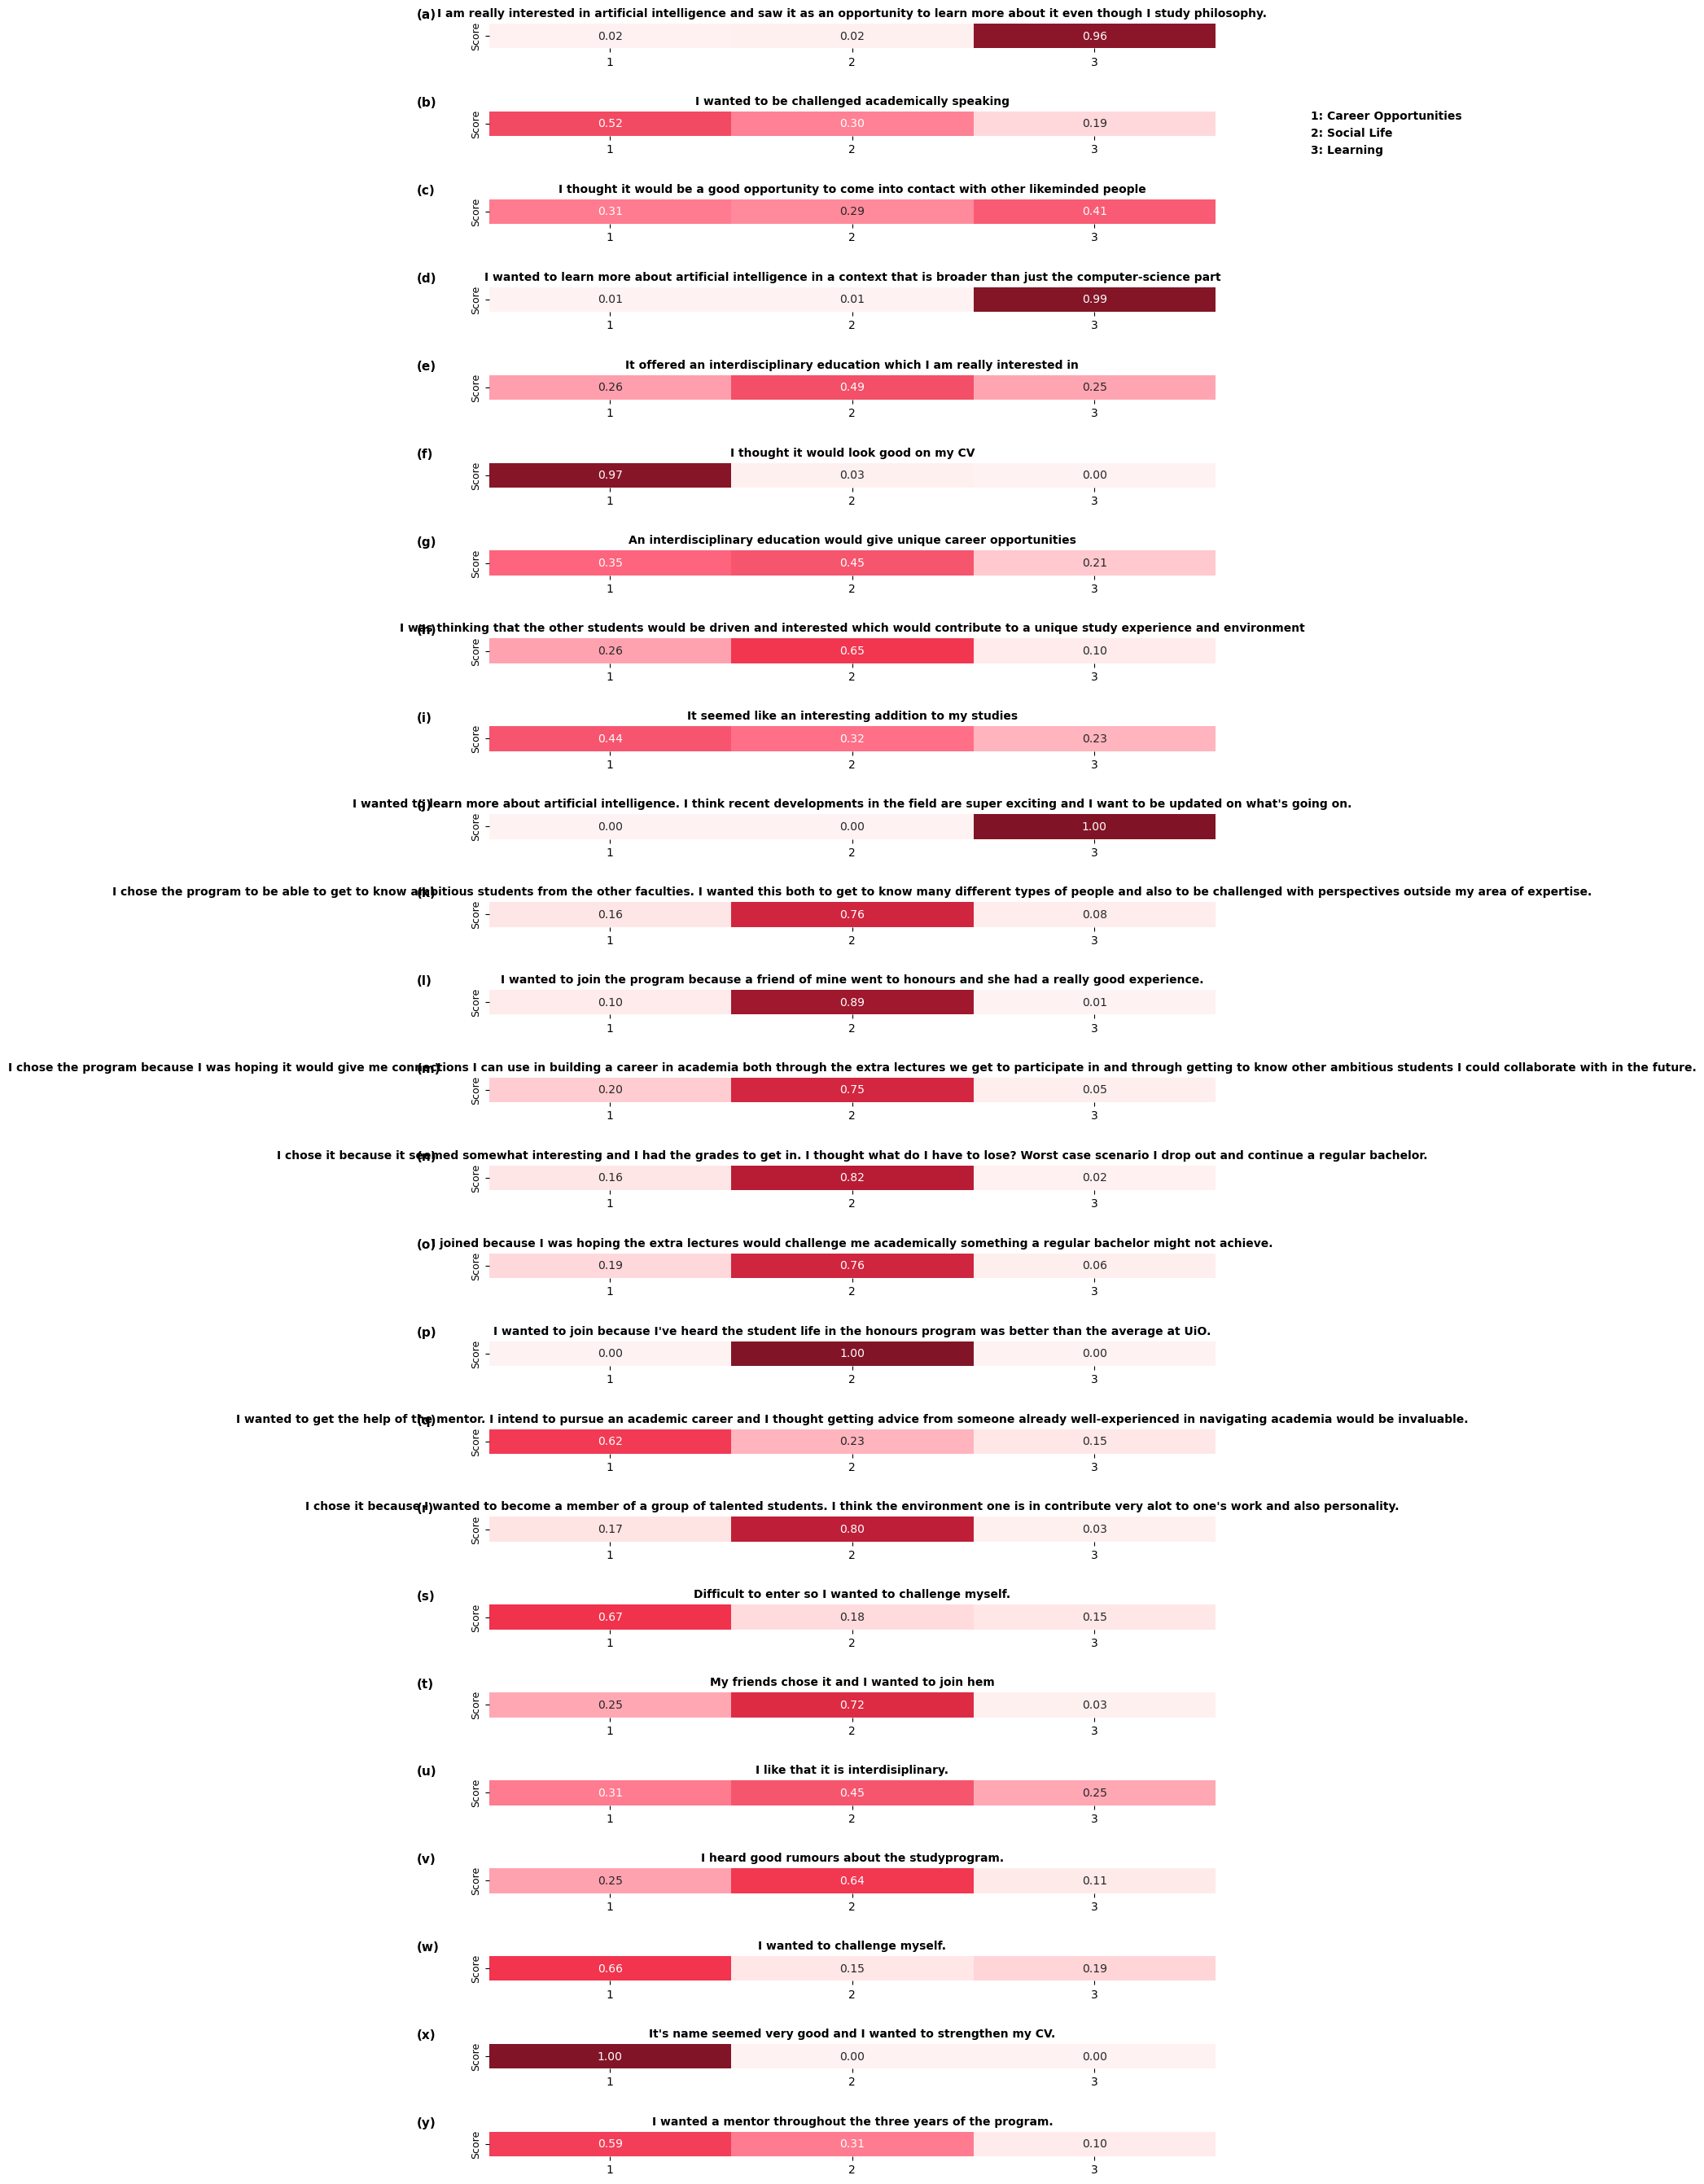

In [79]:
plot_heatmap(list(range(25)), 15, 'cosine', 'exponential', category_names)

In [78]:
# @title Interactive tool
import ipywidgets as widgets

nr_articles_for_heatmap = 25
list_of_widgets = []
style = {'description_width': 'initial'}

for i in range(nr_articles_for_heatmap):
    widget_i = widgets.BoundedIntText(
        value=i,
        min=0,
        max=1761,
        step=1,
        description=f'Text Index:',    
        style=style,
        layout=widgets.Layout(width='80%')
    )
    list_of_widgets.append(widget_i)

alpha_slider = widgets.FloatSlider(
    value=15,
    min=0,
    max=50,
    step=0.1,
    description='Alpha:',
    style=style,
    layout=widgets.Layout(width='90%')
)

metric = widgets.RadioButtons(
    options=['euclidean', 'cosine', 'cityblock'],
    description='Metric:',
    value='cosine',
    style=style,
    layout=widgets.Layout(width='100%')
)

scaling = widgets.RadioButtons(
    options=['power', 'exponential'],
    description='Scaling:',
    value='exponential',
    style=style,
    layout=widgets.Layout(width='100%')
)

for wid in list_of_widgets:
    wid.observe(update_heatmap, names='value')

alpha_slider.observe(update_heatmap, names='value')
metric.observe(update_heatmap, names='value')
scaling.observe(update_heatmap, names='value')


widgets_box_top = widgets.VBox(list_of_widgets[0:4], layout=widgets.Layout(width='20%'))
widgets_box_low = widgets.VBox(list_of_widgets[4:], layout=widgets.Layout(width='20%'))
sub_widget_box_low = widgets.HBox([metric, scaling], layout=widgets.Layout(width='100%'))
widgets_box_lowest = widgets.VBox([alpha_slider, sub_widget_box_low], layout=widgets.Layout(width='30%'))
widgets_box = widgets.HBox([widgets_box_top, widgets_box_low, widgets_box_lowest])

# Output widget
output = widgets.Output()

# Display initial heatmap
with output:
    plot_heatmap([wid.value for wid in list_of_widgets], alpha_slider.value, metric.value, scaling.value, category_names)

display(widgets_box, output)


Output()

### Pie Chart

In [76]:
alpha = 10
metric = 'cosine'
scaling = 'exponential'

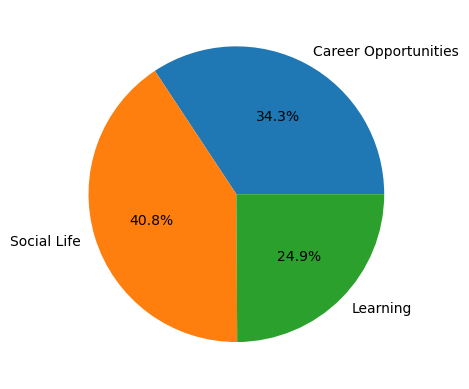

In [77]:
scores = embedding_score(text_embeddings, centroid_embeddings, alpha, metric, scaling)
aggregate=np.sum(scores, axis=0)

plt.pie(aggregate, labels=category_names, autopct="%1.1f%%")
plt.show()